Working skip option as an opinion and include the effect of skip in our approach

In [1]:
import numpy as np
import pandas as pd
import copy #Use for Deep copy

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('D:\\decertation\\data\sentiment analysis dataset\\new_code\\response_matrix.npy', 'rb') as f:
    response_matrix = np.load(f)
print(response_matrix)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [3]:
train = pd.read_csv('D:\\decertation\\data\sentiment analysis dataset\\new_code\\new_gold.csv')
print(train.head())

   Unnamed: 0  original_question   ques  new_judgement
0           0           79186190  73151              1
1           1           79186569  73515              1
2           2           79186651  73592              0
3           3           79186726  73659              1
4           4           79186749  73681              1


In [4]:
judgement_counts = np.bincount(train['new_judgement'])
Negetive = judgement_counts[0]
Positive = judgement_counts[1]
Skip = judgement_counts[2]
print(f'Positive : {Positive}, Negetive : {Negetive}, Skip: {Skip}')

Positive : 190, Negetive : 228, Skip: 25


In [5]:
c, r = len(np.unique(response_matrix))-1, response_matrix.shape[1]
p = r * c

In [6]:
tot_ques = r
print(f'Total question {tot_ques}')

Total question 98980


# Proposed approach for streaming data

Calculating initial accuracy of annotators

In [7]:
s1 = int(len(train)* 0.3)
train2 = train[ : s1]

accuracy = [1 / len(train2)]*response_matrix.shape[0]
for i in range (response_matrix.shape[0]):
    tot, corr = 0.0, 0.0
    for j in range(len(train2)):
        if -1 != response_matrix[i][train2[train2.columns[2]][j]]:
            tot += 1
            if train2[train2.columns[3]][j] == response_matrix[i][train2[train2.columns[2]][j]]:
                corr += 1
    if tot != 0:
        accuracy[i] += corr / tot
minacc = np.min(accuracy)
maxacc = np.max(accuracy)
accuracy = (accuracy - minacc)/ (maxacc-minacc)
print(accuracy[ : 5])

[0.  1.  1.  0.8 0. ]


Required function

In [8]:
def dist(a,b):
    s = 0
    for j in range(len(a)):
        if a[j] != b[j]:
            s += 1
    return s

In [9]:
def difficulty(block, difficulty_list, total):
    total += block.shape[0]
    for j in range(block.shape[1]):
        for i in range(block.shape[0]):
            if block[i][j] == 2:  #block[i][j] == 2 means corresponding response is "Skip"
                difficulty_list[j] += 1
    return difficulty_list, total

In [10]:
def local_directory(row):
    local_dict = {
        'vector': row,
        'frequency': 1,
        'response_number': np.count_nonzero(row != -1)
    }
    return local_dict

In [11]:
#Cluster with distance = hyp
def cluster(cluster_dict, block, hyp):
    cluster_id = []
    distance, i = 0, len(cluster_dict)
    for j in range(len(block)):
        if len(cluster_dict) == 0:
            i += 1
            cluster_dict[i] = local_directory(block[j])
            cluster_id.append(i)

        else:
            l, k = 1, i
            while l <= k:
                d = dist(block[j], cluster_dict[l]['vector'])
                if d <= hyp:
                    cluster_dict[l]['frequency'] += 1
                    cluster_id.append(l)
                    distance += d

                    break
                else:
                    l += 1
                if l == k+1:
                    i += 1
                    cluster_dict[i] = local_directory(block[j])
                    cluster_id.append(i)

    return cluster_dict, cluster_id, distance

In [12]:
#Clustering with finding the distance
def clustering(cluster_dict, block, d):
    # Use ELBOW Method to find the threshold of the distance
    distance_list = []
    
    for it in range (1,100):
        k = it * 100
        cluster_dictionary = copy.deepcopy(cluster_dict)
        _, _, distance = cluster(cluster_dictionary, block, k)
        distance_list.append(distance)


    ratio = [(distance_list[i] - distance_list[i-1]) * 0.001 for i in range(1, len(distance_list))]
    ratio1 = [a for a in ratio if a != 0]
    index = [i for i, a in enumerate(ratio) if a != 0]

    ind_ch = [(ratio1[i] - ratio1[i-1]) / (index[i] - index[i-1]) for i in range(1, len(index))]

    dis = d
    index = next((i for i, val in enumerate(ind_ch[1:], start=1) if val >= 1), None)
    if index is not None:
        a = ind_ch.index(ind_ch[index]) + 1
        dis = ratio.index(ratio1[a]) * 100
                

#     cluster_dict,cluster_id, _ = cluster(cluster_dict, block, dis)   
    return cluster_dict, dis

In [13]:
def judge(J, block, cluster_dict, a, dis, accuracy_list):    
    cluster_dict, cluster_id, _ = cluster(cluster_dict, block, dis)
    
    weight = []
    for k in range(block.shape[0]):
        w = accuracy_list[a + k] + const * cluster_dict[cluster_id[k]]['response_number']/cluster_dict[cluster_id[k]]['frequency']
        weight.append(w)
    
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if block[k][j] != -1:
                J[j][block[k][j]] += weight[k]

    return J, cluster_dict

Main function for Proposed approach

In [14]:
const = 1/ tot_ques
dis = 1000
cluster_dict = {}
J = np.array([0.]*p).reshape(r, c)
Result = np.array([-1]*r)
difficulty_list = [0]*response_matrix.shape[1]
total = 0

In [15]:
a, b = 0, 50

A = response_matrix[a : b]
_, dis = clustering(cluster_dict, A, dis)

while b <= response_matrix.shape[0]:
    
    A = response_matrix[a : b]
    
    #Update the accuracy of the annotators
    difficulty_list, total = difficulty(A, difficulty_list, total)
    
    accuracy_list = copy.deepcopy(accuracy)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if response_matrix[i][j] == 0:
                accuracy_list[a + i] +=  difficulty_list[j] / total 
                
            elif response_matrix[i][j] == 1:
                accuracy_list[a + i] += difficulty_list[j] / total 
        
    
    #Judgement
    J, cluster_dict = judge(J, A, cluster_dict, a, dis, accuracy_list)
    
    # Calculate final result
    Result = np.argmax(J, axis=1)
    
    #Calculate accuracy
    right = np.sum(train[train.columns[3]].values == Result[train[train.columns[2]].values])
            
    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} % ')
    
    a = b
    b += 50

Accuracy after 50 annotators' response is 71.5576 % 
Accuracy after 100 annotators' response is 81.0384 % 
Accuracy after 150 annotators' response is 84.6501 % 
Accuracy after 200 annotators' response is 86.9074 % 
Accuracy after 250 annotators' response is 88.9391 % 
Accuracy after 300 annotators' response is 90.2935 % 
Accuracy after 350 annotators' response is 90.5192 % 
Accuracy after 400 annotators' response is 90.5192 % 
Accuracy after 450 annotators' response is 90.7449 % 
Accuracy after 500 annotators' response is 90.7449 % 
Accuracy after 550 annotators' response is 90.9707 % 
Accuracy after 600 annotators' response is 90.7449 % 
Accuracy after 650 annotators' response is 90.7449 % 
Accuracy after 700 annotators' response is 90.7449 % 
Accuracy after 750 annotators' response is 90.7449 % 
Accuracy after 800 annotators' response is 91.1964 % 
Accuracy after 850 annotators' response is 91.1964 % 
Accuracy after 900 annotators' response is 91.1964 % 
Accuracy after 950 annotators

Confusion matrix

In [16]:
Confusion_matrix = np.zeros((3, 3), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
            
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
            
    elif train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][0] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][1] += 1
print(Confusion_matrix)

[[183   5   2]
 [  3 215  10]
 [  4  11  10]]


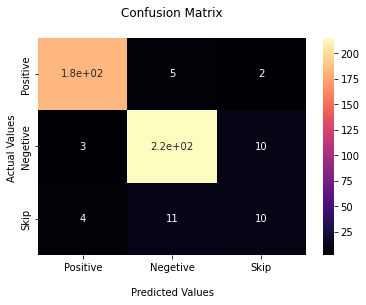

In [17]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
plt.show()

# Majority voting

In [18]:
def majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                J[j][response_matrix[a + k][j]] += 1  
        
    return J

In [19]:
a, b = 0, 50

M = np.array([-1]*p).reshape(r, c)
Majority_Result = np.array([-1]*r)

while b <= response_matrix.shape[0]:
    A = response_matrix[a : b]
    M = majority(M, A, a)
    
    Majority_Result = np.argmax(J, axis=1)
    
    right = np.sum(train[train.columns[3]].values == Majority_Result[train[train.columns[2]].values])

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 50

Accuracy after 50 annotators' response is 92.0993 %
Accuracy after 100 annotators' response is 92.0993 %
Accuracy after 150 annotators' response is 92.0993 %
Accuracy after 200 annotators' response is 92.0993 %
Accuracy after 250 annotators' response is 92.0993 %
Accuracy after 300 annotators' response is 92.0993 %
Accuracy after 350 annotators' response is 92.0993 %
Accuracy after 400 annotators' response is 92.0993 %
Accuracy after 450 annotators' response is 92.0993 %
Accuracy after 500 annotators' response is 92.0993 %
Accuracy after 550 annotators' response is 92.0993 %
Accuracy after 600 annotators' response is 92.0993 %
Accuracy after 650 annotators' response is 92.0993 %
Accuracy after 700 annotators' response is 92.0993 %
Accuracy after 750 annotators' response is 92.0993 %
Accuracy after 800 annotators' response is 92.0993 %
Accuracy after 850 annotators' response is 92.0993 %
Accuracy after 900 annotators' response is 92.0993 %
Accuracy after 950 annotators' response is 92.0

Confusion matrix

In [20]:
Confusion_matrix = np.zeros((3, 3), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
            
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
            
    elif train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][1] += 1
print(Confusion_matrix)

[[183   5   2]
 [  3 215  10]
 [  4  11  10]]


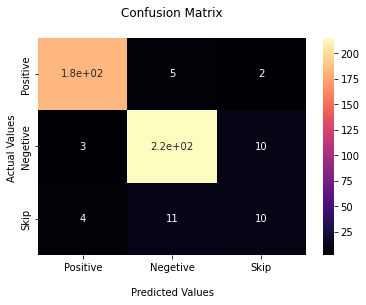

In [21]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
plt.show()

# Weighted Majority Voting

In [22]:
def weighted_majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                J[j][response_matrix[a + k][j]] += accuracy[a + k]
        
    return J

In [23]:
M[0]

array([-1, -1,  2])

In [24]:
a, b = 0, 50

M = np.array([-1.]*p).reshape(r, c)
Weighted_Majority_Result = np.array([-1.]*r)

while b <= response_matrix.shape[0]:
    A = response_matrix[a : b]
    M = weighted_majority(M, A, a)
    
    Weighted_Majority_Result = np.argmax(J, axis=1)
    
    right = np.sum(train[train.columns[3]].values == Weighted_Majority_Result[train[train.columns[2]].values])

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 50

Accuracy after 50 annotators' response is 92.0993 %
Accuracy after 100 annotators' response is 92.0993 %
Accuracy after 150 annotators' response is 92.0993 %
Accuracy after 200 annotators' response is 92.0993 %
Accuracy after 250 annotators' response is 92.0993 %
Accuracy after 300 annotators' response is 92.0993 %
Accuracy after 350 annotators' response is 92.0993 %
Accuracy after 400 annotators' response is 92.0993 %
Accuracy after 450 annotators' response is 92.0993 %
Accuracy after 500 annotators' response is 92.0993 %
Accuracy after 550 annotators' response is 92.0993 %
Accuracy after 600 annotators' response is 92.0993 %
Accuracy after 650 annotators' response is 92.0993 %
Accuracy after 700 annotators' response is 92.0993 %
Accuracy after 750 annotators' response is 92.0993 %
Accuracy after 800 annotators' response is 92.0993 %
Accuracy after 850 annotators' response is 92.0993 %
Accuracy after 900 annotators' response is 92.0993 %
Accuracy after 950 annotators' response is 92.0

In [25]:
Confusion_matrix = np.zeros((3, 3), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
            
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
            
    elif train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][1] += 1
print(Confusion_matrix)

[[183   5   2]
 [  3 215  10]
 [  4  11  10]]


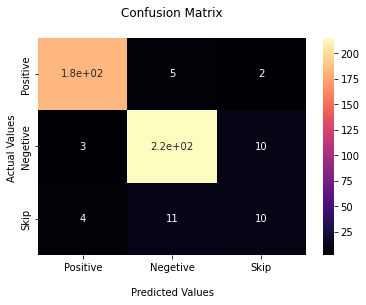

In [26]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive', 'Skip'))
plt.show()